In [113]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob

os.environ['BEEP_ENV'] = 'dev'

In [114]:
from beep import validate, structure, featurize

In [115]:
from matplotlib import pyplot as plt
from monty.serialization import loadfn

In [116]:
data_dir = 'TRI-Capstone/OldData' # Directory for old data
data_dir2 = 'TRI-Capstone/TrajectoryFastCharge' # Directory for TrajectoryFastCharge

In [117]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

In [118]:
def convert_to_float(lst):
    if type(lst) != int:
        return lst[0]
    else:
        return lst

Getting Features

In [133]:
file_list = getListOfFiles(data_dir)
print(len(file_list))
file_list

93


['TRI-Capstone/OldData/b1_CH00_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH01_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH02_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH03_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH04_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH05_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH06_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH07_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH09_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH11_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH14_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH15_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH16_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH17_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH19_features_DeltaQFastCharge.json',
 'TRI-Capstone/OldData/b1_CH20_features_

In [149]:
df = pd.DataFrame()
for file in file_list:
    with open(file) as data_file:    
        data = json.load(data_file)
        data_df = pd.json_normalize(data)
        df = pd.concat([df,data_df])
df.reset_index(drop=True,inplace=True)
df['name'] = df['name'].apply(lambda x: x[177:184])
df.head()

,@module,@class,name,@version,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.internal_resistance_cycle_2,X.internal_resistance_difference_cycles_2:100,X.nominal_capacity_by_median,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.init_pred_cycle,metadata.parameters.mid_pred_cycle,metadata.parameters.final_pred_cycle,metadata.parameters.n_nominal_cycles
0,beep.featurize,DeltaQFastCharge,b1_CH00,2021.1.11.15,[1.0719005],[0.4671539],[1.0758415000000001],[3139.4337303694406],[13.339999198913574],[-0.034721491566765676],...,[0.01674235425889492],[-7.520057260990143e-05],[1.0765049],None,None,None,10,91,100,40
1,beep.featurize,DeltaQFastCharge,b1_CH01,2021.1.11.15,[1.0766124],[0.007977100000000181],[1.0806502],[3030.910080727412],[13.339999198913574],[-0.042352959384753606],...,[0.017038831487298012],[-4.1991472244262695e-05],[1.0818901],None,None,None,10,91,100,40
2,beep.featurize,DeltaQFastCharge,b1_CH02,2021.1.11.15,[1.0813153999999998],[0.006738100000000191],[1.0849447],[3044.688062161791],[13.339999198913574],[-0.03703037288667721],...,[0.016867980360984802],[-1.3807788491249084e-05],[1.0857179499999998],None,None,None,10,91,100,40
3,beep.featurize,DeltaQFastCharge,b1_CH03,2021.1.11.15,[1.0812283],[0.005024700000000104],[1.0846678],[2848.7820297642215],[12.010000228881836],[-0.03704596278395409],...,[0.01636970415711403],[3.858096897602081e-05],[1.0850300000000002],None,None,None,10,91,100,40
4,beep.featurize,DeltaQFastCharge,b1_CH04,2021.1.11.15,[1.0790123999999999],[0.005304200000000314],[1.0825965],[2977.746621443077],[12.010000228881836],[-0.03223409492285186],...,[0.01678742840886116],[-5.331449210643768e-05],[1.0828634],None,None,None,10,91,100,40


Response variable data

In [121]:
file_list2 = getListOfFiles(data_dir2)
file_list2 = file_list2[:len(file_list2)-2]

In [131]:
print(len(file_list2))
file_list2

63


['TRI-Capstone/TrajectoryFastCharge/b1_CH00_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH01_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH02_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH03_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH04_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH05_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH06_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH07_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH09_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH11_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH14_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFastCharge/b1_CH15_features_TrajectoryFastCharge.json',
 'TRI-Capstone/TrajectoryFas

In [160]:
df2 = pd.DataFrame()
for file in file_list2:
    with open(file) as data_file:    
        data = json.load(data_file)
        data_df = pd.json_normalize(data)
        df2 = pd.concat([df2,data_df])
df2.reset_index(drop=True,inplace=True)
df2['name'] = df2['name'].apply(lambda x: x[181:188])
df2.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,b1_CH00,2021.1.11.15,[255],[609],[1389],[1564],[1698],[1805],[1851],None,None,None,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,b1_CH01,2021.1.11.15,[717],[1177],[1699],[1877],[2011],[2112],[2159],None,None,None,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,b1_CH02,2021.1.11.15,[745],[1175],[1485],[1485],[1485],[2192],[2236],None,None,None,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,b1_CH03,2021.1.11.15,[626],[1018],[1160],[1235],[1305],[1387],[1433],None,None,None,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,b1_CH04,2021.1.11.15,[652],[1156],[1380],[1489],[1578],[1663],[1708],None,None,None,0.98,0.78,0.03


In [162]:
# df_full = df.merge(df2,'inner',left_index=True,right_index=True)
df_full = df.merge(df2,'inner',on = 'name')


# Making values not stored as lists
for column in df_full.columns:
    if "X." in column:
        df_full[column] = df_full[column].apply(lambda x: x[0])

df_full

,@module_x,@class_x,name,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,DeltaQFastCharge,b1_CH00,2021.1.11.15,1.071900,0.467154,1.075842,3139.433730,13.339999,-0.034721,...,1564,1698,1805,1851,None,None,None,0.98,0.78,0.03
1,beep.featurize,DeltaQFastCharge,b1_CH01,2021.1.11.15,1.076612,0.007977,1.080650,3030.910081,13.339999,-0.042353,...,1877,2011,2112,2159,None,None,None,0.98,0.78,0.03
2,beep.featurize,DeltaQFastCharge,b1_CH02,2021.1.11.15,1.081315,0.006738,1.084945,3044.688062,13.339999,-0.037030,...,1485,1485,2192,2236,None,None,None,0.98,0.78,0.03
3,beep.featurize,DeltaQFastCharge,b1_CH03,2021.1.11.15,1.081228,0.005025,1.084668,2848.782030,12.010000,-0.037046,...,1235,1305,1387,1433,None,None,None,0.98,0.78,0.03
4,beep.featurize,DeltaQFastCharge,b1_CH04,2021.1.11.15,1.079012,0.005304,1.082596,2977.746621,12.010000,-0.032234,...,1489,1578,1663,1708,None,None,None,0.98,0.78,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,beep.featurize,DeltaQFastCharge,2_CH43_,2021.1.11.15,1.075370,0.005270,1.078844,3297.803636,10.010000,-0.034414,...,414,433,451,461,None,None,None,0.98,0.78,0.03
59,beep.featurize,DeltaQFastCharge,2_CH44_,2021.1.11.15,1.072312,0.004941,1.076151,3295.457606,10.010000,-0.031831,...,416,433,449,456,None,None,None,0.98,0.78,0.03
60,beep.featurize,DeltaQFastCharge,2_CH45_,2021.1.11.15,1.071760,0.003898,1.073080,3250.625921,10.010000,-0.047537,...,441,460,478,486,None,None,None,0.98,0.78,0.03
61,beep.featurize,DeltaQFastCharge,2_CH46_,2021.1.11.15,1.074322,0.005676,1.079305,3222.007904,10.010000,-0.046798,...,395,409,422,428,None,None,None,0.98,0.78,0.03


In [163]:
df_full.keys()

Index(['@module_x', '@class_x', 'name', '@version_x',
       'X.discharge_capacity_cycle_2', 'X.max_discharge_capacity_difference',
       'X.discharge_capacity_cycle_100',
       'X.integrated_time_temperature_cycles_1:100',
       'X.charge_time_cycles_1:5',
       'X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_mean_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.abs_first_discharge_capacity_difference_cycles_2:100',
       'X.max_temperature_cycles_1:100', 'X.min_temperature_cycles_1:100',
       'X.slope_discharge_capacity_cycle_number_2:100',
       'X.intercept_discharge_capacity_cycle_number_2:100',
       'X.slope_discharge_capacity_cycle_number_91:100',
       'X.intercept_discharge_capacity_cycle_number_91:100',
       'X.min_internal_resistance_cycl

Model Recreation

In [126]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5',
                       'X.integrated_time_temperature_cycles_1:100',
                       'X.min_internal_resistance_cycles_2:100',
                       'X.internal_resistance_difference_cycles_2:100']
y = df_full['X.capacity_0.8']

Variance Model

In [127]:
from sklearn.linear_model import LinearRegression

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='X.capacity_0.8'>

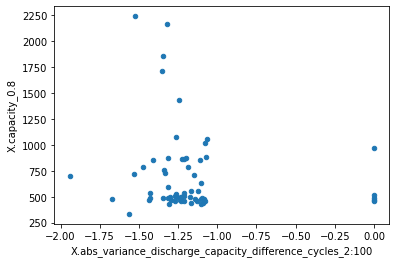

In [164]:
df_full.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = 'X.capacity_0.8')

In [129]:
# X = df_full[variance_model_features].values()
# reg = LinearRegression().fit(X,y)